- title: Playing around with the Strava API
- author: Alexander
- date: 2020-08-20
- category: python
- tags: python, strava, jupyter
- slug: strava-api
- featured_image: images/all_about_the_bike_ascii_edition.png
- Summary: Strava is great and I confess I use it almost daily (despite the concerns I might have about privacy). I've always been into analysing sporting performance data. Recently I signed up to Veloviewer but between it and Strava I can't answer a couple of questions. So I went to the source.

Strava is great and I confess I use it almost daily (despite the concerns I might have about privacy). I've always been into analysing sporting performance data, whether it was poring over musty books full of cricket stats or tracking my 400 metre and long jump PBs. In fact, the earliest memory I have of using a computer to do anything apart from playing games is my father creating old Lotus 123 spreadsheets to analyse the results my sister and I would achieve each week at Little Athletics. This probably tells you something about my family's geekiness (and how old I am) but I remember being transfixed as the database was input and the charts magically updated.

These days fitness tracking apps are all the rage and technologies like GPS mean we can harvest a wealth of data compared to those manually entered and hand timed results from my youth. I wish I still had those spreadsheets though, in fact they may even be sitting on a 5 1/4 inch floppy somewhere at my parents' house. On reflection, I'm not sure I'd enjoy being reminded that I was faster as a twelve year old than as an adult... Luckily, my Strava history only extends back ten years so, while it captures my decline, it doesn't show me at my, er, peak such as it was. 

Strava provides some high level stats out of the box, like total distance covered and average distance per week etc. Recently I signed up to [Veloviewer](https://veloviewer.com/) which pulls in your Strava activities and calculates all sorts of metrics and provides some nice visualisations. In particular, I really like its "Explorer score" which tracks how much of the world you've covered by crunching all the geodata you've uploaded (i.e. "donated") to Strava. 

Still, there were a couple of things I wanted to know that I couldn't access out of the box with either tool. For example, a friend of mine was very proud of her running streak in which she ran every day for over a year. I knew I hadn't come close but was curious to learn how long my cycling streak was. I was also curious as to how many different countries I'd recorded activities in. I travel a fair bit and often run/hike/cycle once I'm there.

It felt like I should be able to answer these questions pretty easily if I had the raw data itself and being curious about what the Strava API offered, I thought I'd grab a key and try to see what I could extract. I should note that if you just want your data, it's easier to just [ask Strava for it](https://support.strava.com/hc/en-us/articles/216918437-Exporting-your-Data-and-Bulk-Export) but it seemed more fun to do it this way.

To [get started](https://developers.strava.com/docs/getting-started/), I logged into Strava and [created an app](https://www.strava.com/settings/api). Since I'm just doing this as a one-off, I didn't jump through all the hoops to get a persistent token via OAuth, instead I just experimented with permissions using the [API playground](https://developers.strava.com/playground/). It means my token expires every few hours but I'm not building an app or a pipeline right now so it doesn't really matter. I saved my token in a ```.env``` file and used dotenv to import it.

In [1]:
from dotenv import load_dotenv
from os import getenv

load_dotenv()
token = getenv("STRAVA_ACCESS_TOKEN")

A number of libraries exist that can assist with connecting to the API but I didn't really investigate them as requests was sufficient for my needs. I also want to use Pandas to do the actual analysis part.

In [2]:
import requests
import pandas as pd

This creates a simple string that can be passed as part of the HTTP headers when hitting an endpoint.

In [3]:
headers = {"Authorization": f"Bearer {token}"}

Now to try a simple API call. In this case, I am just pulling details on the "logged in athlete", i.e. me. 

In [4]:
url = "https://www.strava.com/api/v3/athlete"
r = requests.get(url, headers=headers)
athlete_details = r.json()

I can pick out a few bits of the json response like this for example:

In [5]:
print(
    f"{athlete_details.get('firstname')} rides his bike (mostly) in {athlete_details.get('city')} these days."
)

Alex rides his bike (mostly) in Berlin these days.


Using the user id from the last response, it's possible to pull some high level stats on my less than illustrious athletic career. 

In [6]:
url = (
    f"https://www.strava.com/api/v3/athletes/{athlete_details.get('id')}/stats"
)
r = requests.get(url, headers=headers)
athlete_stats = r.json()

In [7]:
print(
    f"{athlete_details.get('firstname')} once rode {athlete_stats.get('biggest_ride_distance'):.2f} in a day (that's metres though, not miles or kilometres). His biggest ever climb was only {athlete_stats.get('biggest_climb_elevation_gain'):.2f} metres though."
)

Alex once rode 125033.00 in a day (that's metres though, not miles or kilometres). His biggest ever climb was only 327.57 metres though.


In my defence, I live in Berlin these days and it's ridiculously flat. That said, I didn't scale too many steep climbs while I was living in Switzerland either... This endpoint also provides high level totals for running and swimming but it's really the same as the stuff you can get from your profile page. To do some deeper analysis, I wanted to get details of the individual activities. For this we can use the ```athlete/activities``` endpoint.

In [8]:
url = f"https://www.strava.com/api/v3/athlete/activities?per_page=10"
r = requests.get(url, headers=headers)
activities = r.json()

To get an idea of the data returned the keys for a specific activity can be listed

In [9]:
activities[0].keys()

dict_keys(['resource_state', 'athlete', 'name', 'distance', 'moving_time', 'elapsed_time', 'total_elevation_gain', 'type', 'workout_type', 'id', 'external_id', 'upload_id', 'start_date', 'start_date_local', 'timezone', 'utc_offset', 'start_latlng', 'end_latlng', 'location_city', 'location_state', 'location_country', 'start_latitude', 'start_longitude', 'achievement_count', 'kudos_count', 'comment_count', 'athlete_count', 'photo_count', 'map', 'trainer', 'commute', 'manual', 'private', 'visibility', 'flagged', 'gear_id', 'from_accepted_tag', 'upload_id_str', 'average_speed', 'max_speed', 'average_watts', 'kilojoules', 'device_watts', 'has_heartrate', 'heartrate_opt_out', 'display_hide_heartrate_option', 'elev_high', 'elev_low', 'pr_count', 'total_photo_count', 'has_kudoed', 'suffer_score'])

This looks promising, what I want to do now is to extract all of my activities into a pandas dataframe. I have around 5000 activities on Strava and after a bit of tinkering, I worked out that the activities endpoint allows a maximum of 200 results per page. Strava are pretty generous with their API limits and the 25 or so calls this would require should be no problem. With a few lines of Python it's possible to pull all activities into a pandas dataframe.

In [10]:
activities = []

page = 1

url = "https://www.strava.com/api/v3/athlete/activities?per_page=200"

while True:

    # get page of activities from Strava
    r = requests.get(url=f"{url}&page={page}", headers=headers)
    r = r.json()

    # exit if no results, otherwise add to list
    if not r:
        break

    for a in r:
        activities.append(a)

    page += 1

In [11]:
df = pd.DataFrame(activities)

That took a few minutes to run but seems to have done the trick. A quick call to the dataframe's ```describe``` method should show that the result set is sensible.

In [12]:
df.describe()

,resource_state,distance,moving_time,elapsed_time,total_elevation_gain,workout_type,id,upload_id,utc_offset,start_latitude,...,average_speed,max_speed,average_watts,kilojoules,elev_high,elev_low,pr_count,total_photo_count,average_cadence,average_temp
count,5066.0,5066.000000,5066.000000,5.066000e+03,5066.000000,1552.000000,5.066000e+03,4.980000e+03,5066.000000,4936.000000,...,5066.000000,5066.000000,1528.000000,1528.000000,4941.000000,4941.000000,5066.000000,5066.000000,65.000000,140.000000
mean,2.0,4541.564311,1473.547967,3.084665e+04,34.093368,9.860180,1.256097e+09,1.372523e+09,5858.349783,48.308615,...,5.082818,7.810561,93.123102,156.278796,209.658753,180.426938,0.239242,0.012041,70.827692,24.421429
std,0.0,7021.290615,1957.316323,1.992428e+06,98.093369,1.168758,6.851901e+08,7.205323e+08,5004.586086,11.306897,...,91.324773,4.522542,29.804492,209.327853,234.446950,219.778131,0.949467,0.148879,12.433919,5.351081
min,2.0,0.000000,0.000000,1.000000e+00,0.000000,0.000000,6.915503e+07,7.566196e+07,0.000000,-41.249047,...,0.000000,0.000000,0.000000,0.000000,-82.800000,-173.900000,0.000000,0.000000,24.100000,11.000000
25%,2.0,1509.950000,502.000000,6.352500e+02,0.000000,10.000000,9.238188e+08,1.023662e+09,3600.000000,47.555600,...,1.666000,4.000000,74.600000,45.700000,61.100000,34.200000,0.000000,0.000000,61.100000,20.000000
50%,2.0,2504.100000,861.000000,1.164000e+03,19.200000,10.000000,9.240612e+08,1.023916e+09,7200.000000,47.559062,...,3.414500,8.000000,92.000000,82.800000,262.000000,245.200000,0.000000,0.000000,76.700000,24.500000
75%,2.0,4818.100000,1705.500000,2.622000e+03,34.600000,10.000000,1.225273e+09,1.346240e+09,7200.000000,52.491187,...,4.627750,10.600000,110.625000,173.500000,275.400000,247.500000,0.000000,0.000000,79.300000,29.000000
max,2.0,125033.000000,30065.000000,1.418130e+08,3877.500000,10.000000,4.038243e+09,4.321991e+09,46800.000000,60.180635,...,5520.000000,46.500000,267.900000,1890.700000,5174.800000,5167.000000,22.000000,6.000000,81.700000,34.000000


Now that I have the data, it makes sense to try to use some simple visualisations to get a handle on it. I like to use Seaborn on top of matplotlib to make things a bit "prettier" in just a few lines of code.  

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk", palette="deep")

One of the great features of Seaborn is its built in pairplot which allows you to get an idea of how different fields in your dataset correlate with one another. It's also easy to colour the datapoints according to a category. The chart below gives an idea of the correlations between some of the different numeric fields across all my cycling activities. Note, I excluded one activity with a spurious ```average_speed```.

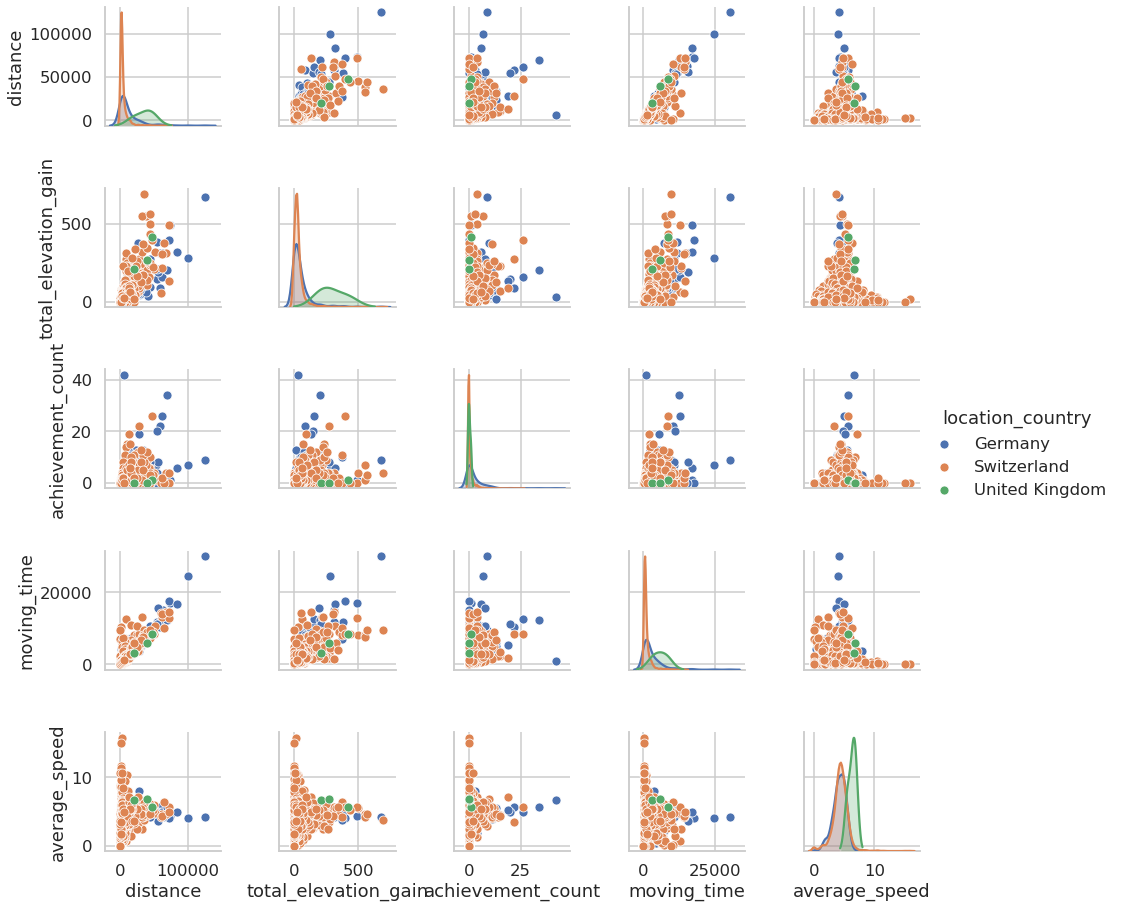

In [14]:
g = sns.pairplot(df[(df["type"] == "Ride") & (df["average_speed"] < 30)], vars = ['distance', 'total_elevation_gain', "achievement_count", "moving_time", "average_speed"], hue="location_country");

The chart above shows that, unsurprisingly, ```distance``` has a strong linear correlation with ```moving_time``` and a weaker one with ```total_elevation_gain```. However the story for ```achievement_count``` is a bit murkier. It's not difficult to understand why, some terrain is a lot flatter than others. Also, the number achievements is going to depend largely on the density of Strava segments, which are likely to be roughly proportional to the number of users in that geographical area. A lot of my longer rides tend to take me outside of densely populated areas.

One thing that's weird is that I know I've recorded activities in Australia and Poland pretty recently but neither appear. I'd also expect to see more from Germany and the UK given that's where I've been these last couple of years. It was simple enough to find an [activity](https://www.strava.com/activities/1363581034) I recorded a while back in Sydney and to pull the relevant fields for it out of the dataframe.

In [15]:
df[df["id"] == 1363581034][
    ["name", "location_country", "start_latitude", "start_longitude"]
]

,name,location_country,start_latitude,start_longitude
1146,Last Sydney ride :(,Switzerland,-33.905934,151.159847


OK, even if I'd given it an erroneous title, the lat/long fields clearly show it wasn't in Switzerland. At first I thought I'd messed up somehow when creating the datraframe but after some more spot testing, it seems the ```location_country``` field reflects where I was living at the time, not where I actually was. This seems to be a bit of a bug/limitation in the Strava API but given that the results include start and end coordinates it should be possible to derive the country using the starting position. Note, having lived so close to the French and German borders in Basel, this isn't entirely accurate but close enough for my purposes.

There are a number of libraries to do reverse geocoding in Python. I could have used something like [geopy](https://github.com/geopy/geopy) to manage the use of an online service like OSM's nominatum but I was curious to try out an offline method so tried out [reverse-geocoder](https://github.com/thampiman/reverse-geocoder) instead. 

In [16]:
import reverse_geocoder as rg

The snippet below should return a result showing that the coordinates correspond to Australia. 

In [17]:
rg.search((-33.905934,151.159847) )

Loading formatted geocoded file...


[{'lat': '-33.90318',
  'lon': '151.15176',
  'name': 'Marrickville',
  'admin1': 'New South Wales',
  'admin2': 'Marrickville',
  'cc': 'AU'}]

Ah good old Marrickville. The ```cc``` field contains the country code so I created a simple function that returns it based on the coordinates which I can then use to create a new column in the dataframe.

In [18]:
def reverse_geo(lat, long):
    if not pd.isna(lat) and not pd.isna(long):
        return rg.search((lat, long))[0]["cc"]

In [19]:
df['start_country'] = df.apply(lambda row: reverse_geo(row.start_latitude, row.start_longitude), axis=1)

Note, that took a while but probably no worse than using Nominatum with a rate limiter (they ask you to limit requests to one per second). For this sort of one off analysis it's perfectly reasonable. Now if I try a catplot based on the start location I should get something a bit more sensible.

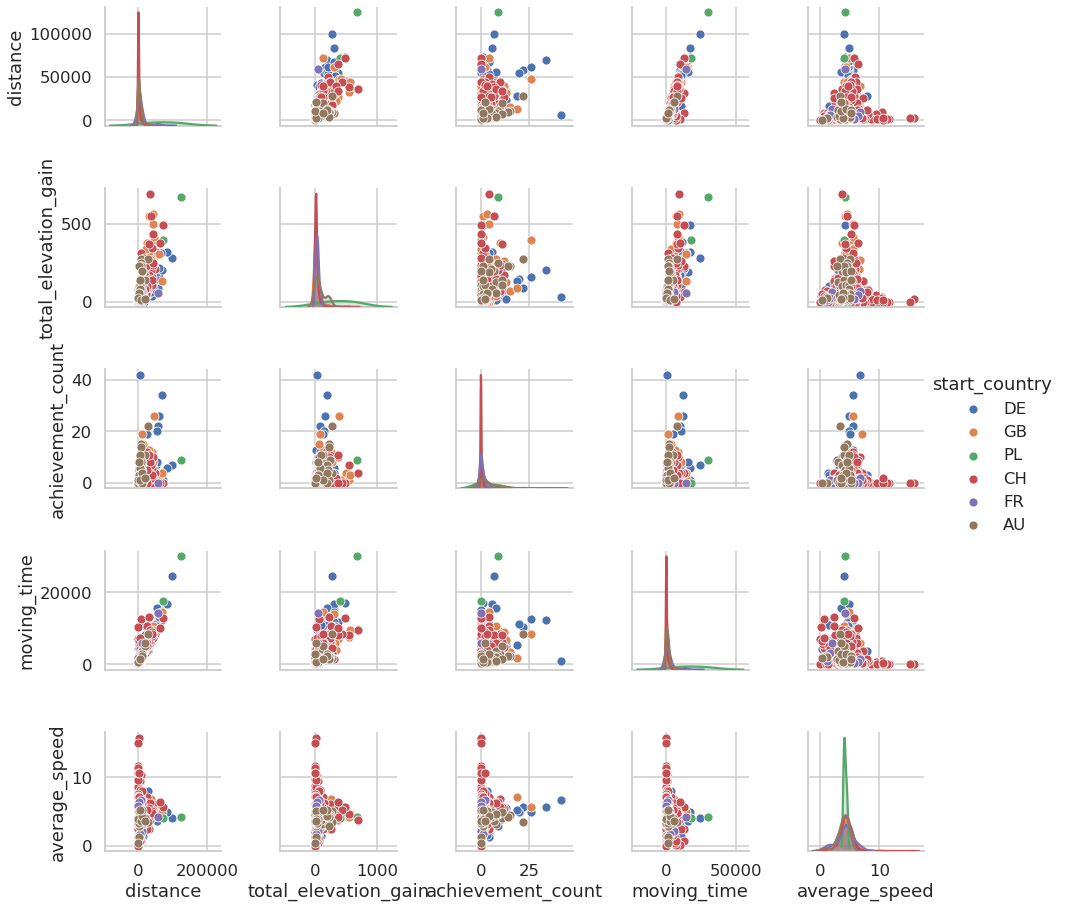

In [20]:
g = sns.pairplot(df[(df["type"] == "Ride") & (df["average_speed"] < 30)], vars = ['distance', 'total_elevation_gain', "achievement_count", "moving_time", "average_speed"], hue="start_country");

That looks more sensible, although it doesn't really give me a feel for how often I've ridden in different countries, a simple count does a better job. I've scratched this particular itch although I had assumed the list would be a bit longer. Other than Poland being a bit of an outlier, it doesn't really tell me much about my cycling habits though. 

In [21]:
df[df['type'] == "Ride"].groupby(['start_country']).count()["id"]

start_country
AU      47
CH    1930
DE     546
FR      18
GB     359
PL       3
Name: id, dtype: int64

If I include all activity types, I get a slightly longer list. I even had to Google some of these country codes... 

In [134]:
df.groupby(['start_country']).count()["id"]

start_country
AT       1
AU      82
BA       3
CH    2982
CN       2
CZ       2
DE     594
DK       4
ES       9
FI       3
FR      50
GB    1156
HK       2
HR       3
HU       2
IT      18
ME       7
NL       3
NO       2
NZ       1
PL       4
PT       1
RU       1
SE       1
TH       3
Name: id, dtype: int64

What about my longest cycling streak though? Each activity record contains the ```start_date``` and  ```start_date_local```. Either will probably give me a rough idea of what I'm looking for. First, I need to convert one of the data columns from a string to an actual datetime instance.

In [200]:
df['date'] = pd.to_datetime(df['start_date_local']).dt.date

What follows is a bit of a hack really but it seems to work. I've often read that as soon as you start looping over the rows in a dataframe, you're doing it all wrong but despite an attempt to search for a solution on Stack Overflow, I just thought I'd get on with my life. Essentially I dump the activity types and the dates into a new dataframe, order it then looping through while keeping track of the longest sequence of consecutive days represented.

In [204]:
df2 = df[['type', 'date']].drop_duplicates(subset=None, keep='first', inplace=False)

In [205]:
df2 = df2.sort_values(['type', 'date']).sort_values(['type', 'date'])

In [206]:
longest = 0
streak = 0
first_day = None

for index, row in df2[df2['type'] == "Ride"].iterrows():
    
    day = row['date']
    
    if not first_day or day - last_day > datetime.timedelta(days=1):
        first_day = day
        last_day = day
        streak = 1
    else:
        last_day = day
        streak = streak + 1
    
    if streak > longest:
        longest = streak

In [207]:
print(longest)

38


I'm actually a little surprised that it isn't a little higher but I guess it's more than a month. Maybe I can re-visit this later and see if I've managed to get it up to 50 but I certainly can't claim any bragging rights from my friend. 